**Problem Statement** : This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation based on [Neural Machine Translation By Jointly Learning To Align and Translate](https://arxiv.org/pdf/1409.0473.pdf) 

### **Project Setup**

In [ ]:
!pip install "tensorflow-text==2.8.*" 

### **Import libraries**

In [ ]:
import re
import io
import os
import time
from string import digits

import numpy as np
import pandas as pd 
import tensorflow as tf
import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split 

### **Download and Prepare the data**

We will use a language dataset provided by  http://www.manythings.org/anki/. 

In [ ]:
# Download the file
import pathlib

zip_file_path = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

file_path = pathlib.Path(zip_file_path).parent/'spa-eng/spa.txt'

In [ ]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines[:60000]]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp 

In [ ]:
target, input = load_data(file_path)
print(input[-1]) 
print(target[-1])

¿Me puedes dejar solo, por favor?
Can you please leave me alone?


### **Create Train and Validation Dataset**

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input, target, test_size=0.001)

### **Create a tf.data dataset**

Convert array of strings into tf.data.Datset of strings to shuffle and batch them efficiently.

In [ ]:
# Create train dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE) 
input_train_batch, target_train_batch = next(iter(train_dataset)) 

### **Text preprocessing**

Text preprocessing steps:

1. Convert special characters
2. Convert to lower case
3. Remove digits
4. Remove spaces
5. Add START and END tags to each sentence

In [ ]:
def preprocess_text(text):

  # Split accecented characters and replace compatibility characters with their ASCII equivalents.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ') 
  # Strip whitespace.
  text = tf.strings.strip(text)
  # Add a start and end token to each sentence.
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

### **Text Vectorization**: Text to Integer

Above standardization function is wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [ ]:
# Training TextVectorization Layer
max_vocab_size = 5000 

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=preprocess_text,
    max_tokens=max_vocab_size) 

The TextVectorization layer have an adapt method. This method reads one epoch of the training data, and works a lot like Model.fix. This adapt method initializes the layer based on the data.

In [ ]:
input_text_processor.adapt(input_tensor_train)

In [ ]:
# Validation TextVectorization Layer
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=preprocess_text,
    max_tokens=max_vocab_size) 

In [ ]:
output_text_processor.adapt(target_tensor_train)

In [ ]:
print(input_train_batch[1])
input_tokens = input_text_processor(input_train_batch)
print(input_tokens[1]) 

tf.Tensor(b'\xc2\xbfQu\xc3\xa9 respondiste?', shape=(), dtype=string)
tf.Tensor([   2    6   10 4860    5    3    0    0    0    0    0    0], shape=(12,), dtype=int64)


In [ ]:
print(target_train_batch[1])
target_tokens = output_text_processor(target_train_batch)
print(target_tokens[1]) 

tf.Tensor(b'What did you answer?', shape=(), dtype=string)
tf.Tensor([  2  29  41   6 256   7   3   0   0   0], shape=(10,), dtype=int64)


In [ ]:
# Training data
max_source_length= max(len(t) for t in  input_tokens)
print(max_source_length)
max_target_length= max(len(t) for t in  target_tokens)
print(max_target_length)

12
10


The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 0.98, 'Training Data Token Ids')

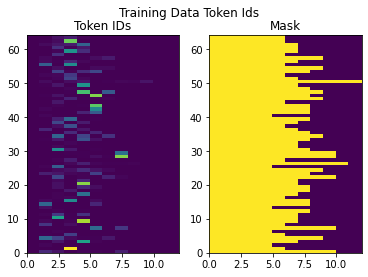

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(input_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2) 
plt.pcolormesh(input_tokens != 0)
plt.title('Mask')
plt.suptitle('Training Data Token Ids')

Text(0.5, 0.98, 'Validation Data Token Ids')

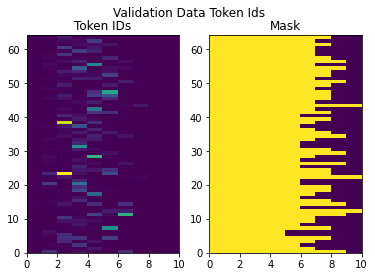

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(target_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2) 
plt.pcolormesh(target_tokens != 0)
plt.title('Mask')
plt.suptitle('Validation Data Token Ids')

### **The Encoder**

Inputs:
* Input Data: A list of token IDs (from input_text_processor).

* Embedding Layer: Embedding vector for each token(using a layers.Embedding).

Returns:

* Processed sequence: Generated sequence(using a layers.GRU). This will be passed to the attention head.   

* Internal state. The internal state of the Encoder. This will be used to initialize the decoder.


In [ ]:
EMBEDDING_DIMENSION = 256
UNITS = 1024 
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
start_index = output_text_processor.get_vocabulary().index('[START]')  

"glorot_uniform" has been used as a recurrent_initializer. It draws from a uniform distribution within [-limit, limit], where limit = sqrt(6/(fan_in+fan_out)). fan_in is the number of input units in the weight tensor and fan_out is the number of output units.

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dimension, encoder_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.encoder_units = encoder_units
    self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dimension)
    self.gru_layer = tf.keras.layers.GRU(self.encoder_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, input, hidden_state):
    input = self.embedding_layer(input)
    output, state = self.gru_layer(input, initial_state = hidden_state)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.encoder_units))

In [ ]:
encoder = Encoder(max_vocab_size, EMBEDDING_DIMENSION, UNITS, BATCH_SIZE)

### **The Attention Head**:
Bahdanau's Additive Attention(Find the attention weight for each token)

Inputs:

* Processed sequence: From the Encoder

* The query: This will be generated by the decoder, later.

* The value: This will be the output of the encoder.

* The mask: To exclude the padding, input_tokens != 0.

Returns:

* Attention weights: Normalized output score of a feed-forward neural network described by the function that captures the alignment between input and output.

* Context vector: Weighted sum of attention weights


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    enc_output_seq = tf.expand_dims(query, 1)
    attention_score = self.V(tf.nn.tanh(self.W1(values) + self.W2(enc_output_seq)))
    attention_weights = tf.nn.softmax(attention_score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### **The Decoder:**

Inputs:

* Context Vector: From Attention layer

* Decoder’s Output: From the previous time step

* Decoder’s Hidden State: Previous Decoder’s hidden state

Returns:

* Decoder’s Hidden State

* Output Tokens: Token IDs for output sentence


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dimension, decoder_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.decoder_units = decoder_units
    self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dimension)
    self.gru_layer = tf.keras.layers.GRU(self.decoder_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.dense_layer = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.decoder_units)

  def call(self, input, hidden_state, enc_output):
    context_vector, attention_weights = self.attention(hidden_state, enc_output)
    input = self.embedding_layer(input)
    input = tf.concat([tf.expand_dims(context_vector, 1), input], axis=-1)
    output, state = self.gru_layer(input)
    output = tf.reshape(output, (-1, output.shape[2]))
    input = self.dense_layer(output)

    return input, state, attention_weights

In [ ]:
decoder = Decoder(max_vocab_size, EMBEDDING_DIMENSION, UNITS, BATCH_SIZE)

### **Define the optimizer and the loss function**

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### **Save Checkpoints**

In [ ]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

### **Training**


**Training Process:**
1. **Encoder:** Input: Source Data(Spanish Sentence) **|** Output: Encoder Output, Encoder Hidden State
2. **Decoder:** Input: Encoder Output, Encoder Hidden State, Start Token **|** Output: Prediction(English Sentence), Decoder Hidden State
3. **Model:** Input: Decoder Hidden State **|** Output: Loss from Prediction
4. **Teaching Force**: Used to decide Target Word to be sent as Next Input to the Decoder
5. **Backpropagate**: Backpropagate the values and repeat the process

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([start_index]* BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input 
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 100
for epoch in range(EPOCHS):
  training_start_time = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    input_tokens = input_text_processor(inp)
    output_tokens = output_text_processor(targ)
    batch_loss = train_step(input_tokens, output_tokens, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
         
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - training_start_time))

Epoch 1 Batch 0 loss 5.655651092529297
Epoch 1 Batch 100 loss 2.767324209213257
Epoch 1 Batch 200 loss 2.4185187816619873
Epoch 1 Batch 300 loss 2.0882980823516846
Epoch 1 Batch 400 loss 2.1111724376678467
Epoch 1 Batch 500 loss 1.824370265007019
Epoch 1 Batch 600 loss 1.7562631368637085
Epoch 1 Batch 700 loss 1.4237140417099
Epoch 1 Batch 800 loss 1.2115468978881836
Epoch 1 Batch 900 loss 1.226518988609314
Epoch 1 Loss 2.0315
Time taken for 1 epoch 247.60581469535828 sec

Epoch 2 Batch 0 loss 1.1962755918502808
Epoch 2 Batch 100 loss 1.148734211921692
Epoch 2 Batch 200 loss 0.9925583004951477
Epoch 2 Batch 300 loss 0.9527276158332825
Epoch 2 Batch 400 loss 1.1758780479431152
Epoch 2 Batch 500 loss 0.8466014266014099
Epoch 2 Batch 600 loss 0.8898126482963562
Epoch 2 Batch 700 loss 0.9247875213623047
Epoch 2 Batch 800 loss 0.8965784311294556
Epoch 2 Batch 900 loss 0.6605995297431946
Epoch 2 Loss 0.9662
Time taken for 1 epoch 85.40215945243835 sec

Epoch 3 Batch 0 loss 0.6948279142379761

### **Translate**

* The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token* or when the max target length is reached.
* Store the attention weights for every time step.

In [ ]:
def evaluate(sentence):

  attention_plot = np.zeros((max_target_length, max_source_length))

  inputs = input_text_processor(sentence)
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_source_length, padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = [tf.zeros((1, UNITS))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([start_index], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
 
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    # Don't show 'START', '.', 'END', 'UNK' in the prediction sentence
    if predicted_id not in range(0,5):
      result += output_text_processor.get_vocabulary()[predicted_id] + ' '

    if output_text_processor.get_vocabulary()[predicted_id] == '[END]':
      return result, sentence, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

**Plot Actual and Predicted Sentences**

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted Translation: {}'.format(result))
  # print("Actual Translation: I've saved the best for last")
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' ')) 

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: Guardé lo mejor para el final
Predicted Translation: ive saved the best for last 
Actual Translation: I've saved the best for last


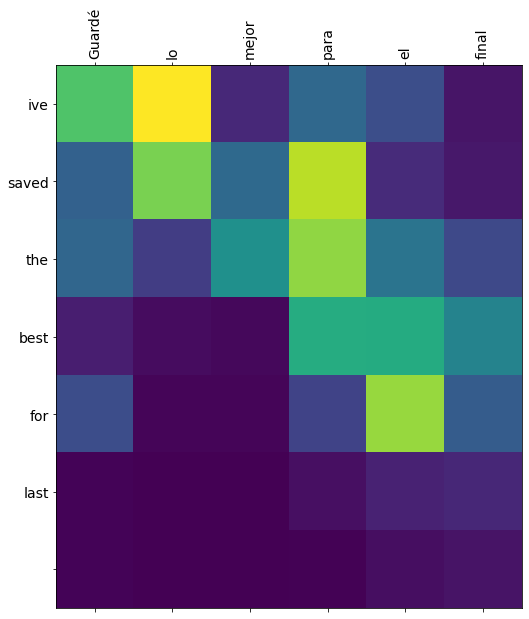

In [ ]:
translate(u'Guardé lo mejor para el final') 

**Predictions of Evaluation Data**

In [ ]:
for i in range(0,10):
  result, sentence, attention_plot = evaluate(input_tensor_val[i])
  print(f'Input Spanish Sentence:{input_tensor_val[i]}')
  print(f'Predicted English Sentence:{result}')
  print(f'Actual English Sentence:{target_tensor_val[i]}\n\n')

Input Spanish Sentence:Eres ingenua.
Predicted English Sentence:youre disorganized 
Actual English Sentence:You're gullible.


Input Spanish Sentence:Ello ha estado ahí por un rato.
Predicted English Sentence:it was just been for a while 
Actual English Sentence:It's been there a while.


Input Spanish Sentence:¿Qué trataste de hacer?
Predicted English Sentence:what are you trying to do ? 
Actual English Sentence:What did you try to do?


Input Spanish Sentence:Tom le asignó el trabajo a Mary.
Predicted English Sentence:tom called mary the job 
Actual English Sentence:Tom assigned the job to Mary.


Input Spanish Sentence:Me tienes a mí.
Predicted English Sentence:youve got me 
Actual English Sentence:You've got me.


Input Spanish Sentence:¿Podés hablar en francés?
Predicted English Sentence:can you speak french ? 
Actual English Sentence:Can you speak French?


Input Spanish Sentence:Le compré a ella un nuevo coche.
Predicted English Sentence:i bought her a new car 
Actual English Se